# Desafio Cientista de Dados INDICIUM - Davi Ribeiro

## Price Prediction without outliers

### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("teste_indicium_precificacao.csv")
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
# First removing the unnecessary columns
df.drop(
    columns=['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'latitude', 
             'longitude', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count',], 
    inplace=True
    )

In [4]:
df.isna().sum()

bairro                 0
room_type              0
price                  0
minimo_noites          0
numero_de_reviews      0
disponibilidade_365    0
dtype: int64

First of all, we have some categorical variables, so we have to transform them into numeric variables, but we have a difficult situation on our hands. The variable *'bairro'* has 221 different values, but on this problem I think that the small granularity of the *'bairro'* is a big problem talking about dimensionality, , but it will probably be a good resource for predicting the price, bacause if I restrict it to *'bairro_group'*, I will lose a lot of information, for example two _'bairros'_ on Brooklyn, but one has more violent crimes than the other, using Brooklyn instead of using the _'bairros'_ will make the model miss this information. So, I'm going to use the *'bairro'* as a feature to predict the price. I will use the **_One Hot Encoding_** to transform the categorical variable into numerical variable, this may increase the cost of the model, but I think that it will be worth the pity.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bairro               48894 non-null  object
 1   room_type            48894 non-null  object
 2   price                48894 non-null  int64 
 3   minimo_noites        48894 non-null  int64 
 4   numero_de_reviews    48894 non-null  int64 
 5   disponibilidade_365  48894 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.2+ MB


### Removing Outliers with IQR rule

I choose to make this outlier cleaning through the IQR rule, because it is a simple and effective way to remove outliers, and for that task I will do it through the *room_types*.

In [6]:
entire = (df['room_type'] == 'Entire home/apt')

Q1_entire = df[entire]['price'].quantile(0.25)
Q3_entire = df[entire]['price'].quantile(0.75)
IQR_entire = Q3_entire - Q1_entire

# Making lower bound too only to make sure, but as we saw on boxplot, 
# all the outliers are over the upper bound
lower_bound_entire = Q1_entire - 1.5 * IQR_entire
upper_bound_entire = Q3_entire + 1.5 * IQR_entire

df_entire = df[entire][(df[entire]['price'] >= lower_bound_entire) & (df[entire]['price'] <= upper_bound_entire)]

In [7]:
private = (df['room_type'] == 'Private room')

Q1_private = df[private]['price'].quantile(0.25)
Q3_private = df[private]['price'].quantile(0.75)
IQR_private = Q3_private - Q1_private

lower_bound_private = Q1_private - 1.5 * IQR_private
upper_bound_private = Q3_private + 1.5 * IQR_private

df_private = df[private][(df[private]['price'] >= lower_bound_private) & (df[private]['price'] <= upper_bound_private)]

In [8]:
shared = (df['room_type'] == 'Shared room')

Q1_shared = df[shared]['price'].quantile(0.25)
Q3_shared = df[shared]['price'].quantile(0.75)
IQR_shared = Q3_shared - Q1_shared

lower_bound_shared = Q1_shared - 1.5 * IQR_shared
upper_bound_shared = Q3_shared + 1.5 * IQR_shared

df_shared = df[shared][(df[shared]['price'] >= lower_bound_shared) & (df[shared]['price'] <= upper_bound_shared)]

In [9]:
df_no_outlier = pd.concat([df_shared, df_private, df_entire])

In [10]:
df.shape[0]

48894

In [11]:
df_no_outlier.shape[0]

45650

3244 lines removed from the original data.

In [12]:
df_no_outlier.reset_index(drop=True, inplace=True)

As I know that dimensionality is a problem, I will change the type of columns to make better use of memory.

In [13]:
for col in df_no_outlier.columns[2:]:
    print(f'{col} - Min: {df_no_outlier[col].min()} - Max: {df_no_outlier[col].max()}')

price - Min: 0 - Max: 392
minimo_noites - Min: 1 - Max: 1250
numero_de_reviews - Min: 0 - Max: 629
disponibilidade_365 - Min: 0 - Max: 365


With that information of min and max of each column, we are able to use the correct type to save memory space:

- uint8 is 0 to 255;
- uint16 is 0 to 65535;
  
So, we can use uint8 for the columns that have a max of 255 and uint16 for the columns that have a max of 65535

In [14]:
# Using price as integer only because the price on this dataset doensn't have float values
df_no_outlier['price'] = df_no_outlier['price'].astype('uint16')
df_no_outlier['minimo_noites'] = df_no_outlier['minimo_noites'].astype('uint16')
df_no_outlier['numero_de_reviews'] = df_no_outlier['numero_de_reviews'].astype('uint16')
df_no_outlier['disponibilidade_365'] = df_no_outlier['disponibilidade_365'].astype('uint16')

In [15]:
df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45650 entries, 0 to 45649
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bairro               45650 non-null  object
 1   room_type            45650 non-null  object
 2   price                45650 non-null  uint16
 3   minimo_noites        45650 non-null  uint16
 4   numero_de_reviews    45650 non-null  uint16
 5   disponibilidade_365  45650 non-null  uint16
dtypes: object(2), uint16(4)
memory usage: 1.0+ MB


In [16]:
df_no_outlier = pd.concat((df_no_outlier, pd.get_dummies(df_no_outlier['room_type'], dtype=np.uint8)), axis=1).drop(columns=['room_type'])

In [17]:
df_no_outlier = pd.concat((df_no_outlier, pd.get_dummies(df_no_outlier['bairro'], dtype=np.uint8)), axis=1).drop(columns=['bairro']).reset_index(drop=True)

In [18]:
df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45650 entries, 0 to 45649
Columns: 225 entries, price to Woodside
dtypes: uint16(4), uint8(221)
memory usage: 10.0 MB


Doing the One-Hot Encoding, we can see that we went from 6 columns to 225 (3 less than without outliers, it means that we lost 3 _'bairros'_), and the memory usage increased 10x, but as I said earlier, that is expected, and I think that it will be worth it.

In [19]:
from tabulate import tabulate

# Function to print the metrics for the regression models
def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred).round(2)
    rmse = root_mean_squared_error(y_true, y_pred).round(2)
    r2 = r2_score(y_true, y_pred).round(2)

    metrics_data = [
        ['Root Mean Squared Error', rmse],
        ['Mean Absolute Error', mae],
        ['R-squared', r2],
    ]

    table = tabulate(metrics_data, headers=['Metric', 'Score'], tablefmt='pretty')

    print("Regression Report:")
    print(table)

    return rmse, mae, r2

For metrics, I will use 3 to look at, but only 2 for real evaluation, they are Root Mean Squared(RMSE) and R-Squared(r2). I'm like to use RMSE because it's a good metric that measures mean squared errors, but when the root is applied the error measure is on the same scale as its variable, so if my RMSE is 50, it means I'm predicting wrong on average. 50+ or 50-. And I like to use R2 because it's a good statistical measure to see if the percentage of actual variation in the data is similar to the prediction, so closer to 1 is better.

In [20]:
# Splitting the data between features and target
X = df_no_outlier.drop(columns=['price']).values
y = df_no_outlier['price'].values

In [21]:
# Splitting the data between train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Let's normalize the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# Using joblib to save the scaler
joblib.dump(scaler, 'scaler_no_outlier.pkl')

['scaler_no_outlier.pkl']

To load the scaler is very simple:

```scaler = joblib.load('scaler.pkl')```

### Using the models

#### Gradient Boosting Regressor

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [46]:
rmse_gbr, mae_gbr, r2_gbr = regression_report(y_test, gbr.predict(X_test))

Regression Report:
+-------------------------+-------+
|         Metric          | Score |
+-------------------------+-------+
| Root Mean Squared Error | 49.08 |
|   Mean Absolute Error   | 35.37 |
|        R-squared        | 0.55  |
+-------------------------+-------+


#### Support Vector Regressor

In [47]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [48]:
rmse_svr, mae_svr, r2_svr = regression_report(y_test, svr.predict(X_test))

Regression Report:
+-------------------------+-------+
|         Metric          | Score |
+-------------------------+-------+
| Root Mean Squared Error | 53.1  |
|   Mean Absolute Error   | 35.65 |
|        R-squared        | 0.47  |
+-------------------------+-------+


#### Random Forest Regressor

In [49]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
rmse_random_forest, mae_random_forest, r2_random_forest = regression_report(y_test, random_forest.predict(X_test))

Regression Report:
+-------------------------+-------+
|         Metric          | Score |
+-------------------------+-------+
| Root Mean Squared Error | 50.01 |
|   Mean Absolute Error   | 34.79 |
|        R-squared        | 0.53  |
+-------------------------+-------+


#### XGBoost Regressor

In [51]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=1000, max_depth=7, random_state=42, learning_rate=0.001, n_jobs = -1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
rmse_xgb, mae_xgb, r2_xgb = regression_report(y_test, xgb.predict(X_test))

Regression Report:
+-------------------------+-------------------+
|         Metric          |       Score       |
+-------------------------+-------------------+
| Root Mean Squared Error | 54.4900016784668  |
|   Mean Absolute Error   | 40.54999923706055 |
|        R-squared        |       0.45        |
+-------------------------+-------------------+


Looking here, we can see a HUGE improvement on RMSE and R-squared, with outliers the smallest RMSE was 208 on NN, here, the biggest is 54.5, and the biggest R-squared was 0.13, here is 0.55, so I think that the outlier cleaning was a good choice.

#### Neural Network

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [24]:
# Callback function to save the best model based best RMSE

class SaveBestModel(Callback):
    def __init__(self,filepath_weights):
        super(SaveBestModel, self).__init__()
        self.filepath_weights = filepath_weights
        self.best_metric = 1e3

    def on_epoch_end(self, epoch, logs=None):
        val_metric = logs['val_root_mean_squared_error']
        if val_metric < self.best_metric:
            self.best_metric = val_metric
            self.model.save_weights(f"{self.filepath_weights}_{(self.best_metric) :.2f}.h5", overwrite=True)
            print(f"\nModel saved with validation accuracy: {val_metric:.4f}")


In [25]:
# Creating the Neural Network

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="relu"))

opt = tf.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.Huber()
rmse_metric = tf.keras.metrics.RootMeanSquaredError()
r2_metric = tf.keras.metrics.MeanSquaredError()

model.compile(optimizer=opt, loss=loss_fn, metrics=[rmse_metric, r2_metric])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                14400     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16513 (64.50 KB)
Trainable params: 16513 (64.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
epochs = 1000
hist = model.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 callbacks=[SaveBestModel(filepath_weights='model_weights')],
                 batch_size=128,
                 verbose=1)


Epoch 1/1000

270/286 [===========================>..] - ETA: 0s - loss: 76.4703 - root_mean_squared_error: 103.2491 - mean_squared_error: 10660.3730
Model saved with validation accuracy: 53.0317
286/286 [==============================] - 1s 1ms/step - loss: 74.9126 - root_mean_squared_error: 101.6749 - mean_squared_error: 10337.7764 - val_loss: 35.2327 - val_root_mean_squared_error: 53.0317 - val_mean_squared_error: 2812.3579
Epoch 2/1000
268/286 [===========================>..] - ETA: 0s - loss: 44.1761 - root_mean_squared_error: 63.0730 - mean_squared_error: 3978.2061
Model saved with validation accuracy: 50.9020
286/286 [==============================] - 0s 1ms/step - loss: 44.1144 - root_mean_squared_error: 62.9655 - mean_squared_error: 3964.6550 - val_loss: 33.6489 - val_root_mean_squared_error: 50.9020 - val_mean_squared_error: 2591.0154
Epoch 3/1000
275/286 [===========================>..] - ETA: 0s - loss: 43.0378 - root_mean_squared_error: 61.6801 - mean_squared_error: 3804.4

In [ ]:
# Save the model on a .pkl file
joblib.dump(model, 'model_neural_network_no_outlier.pkl')

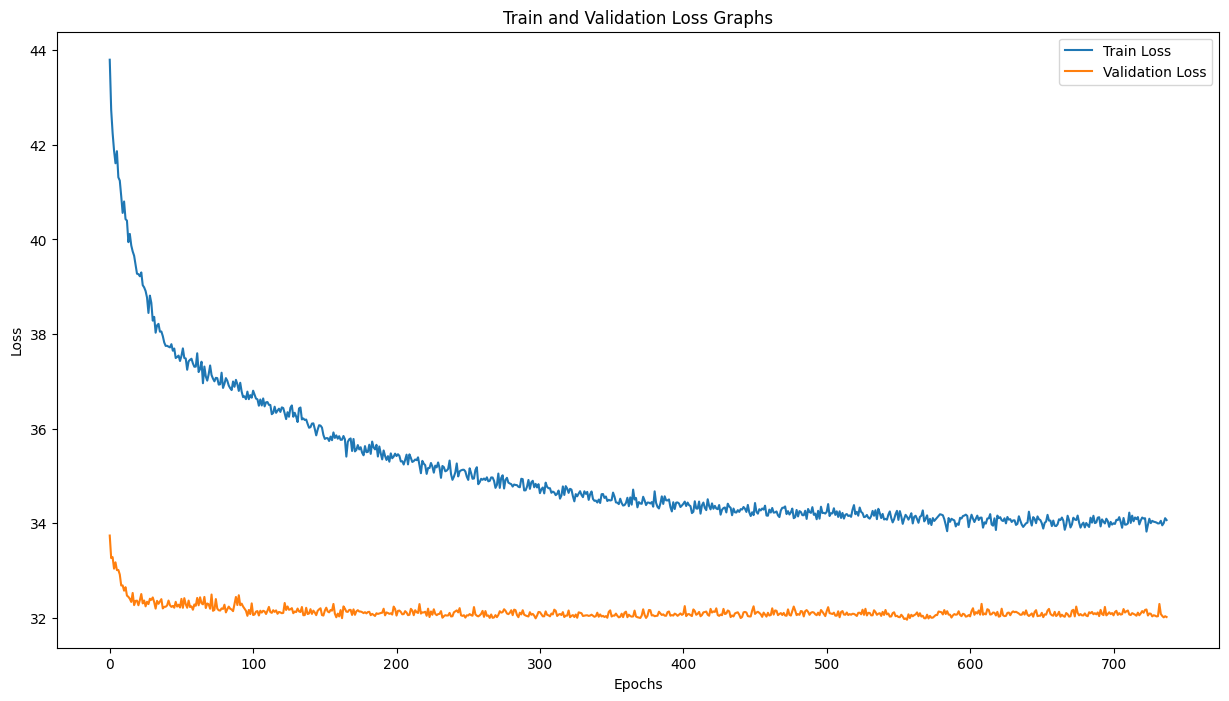

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


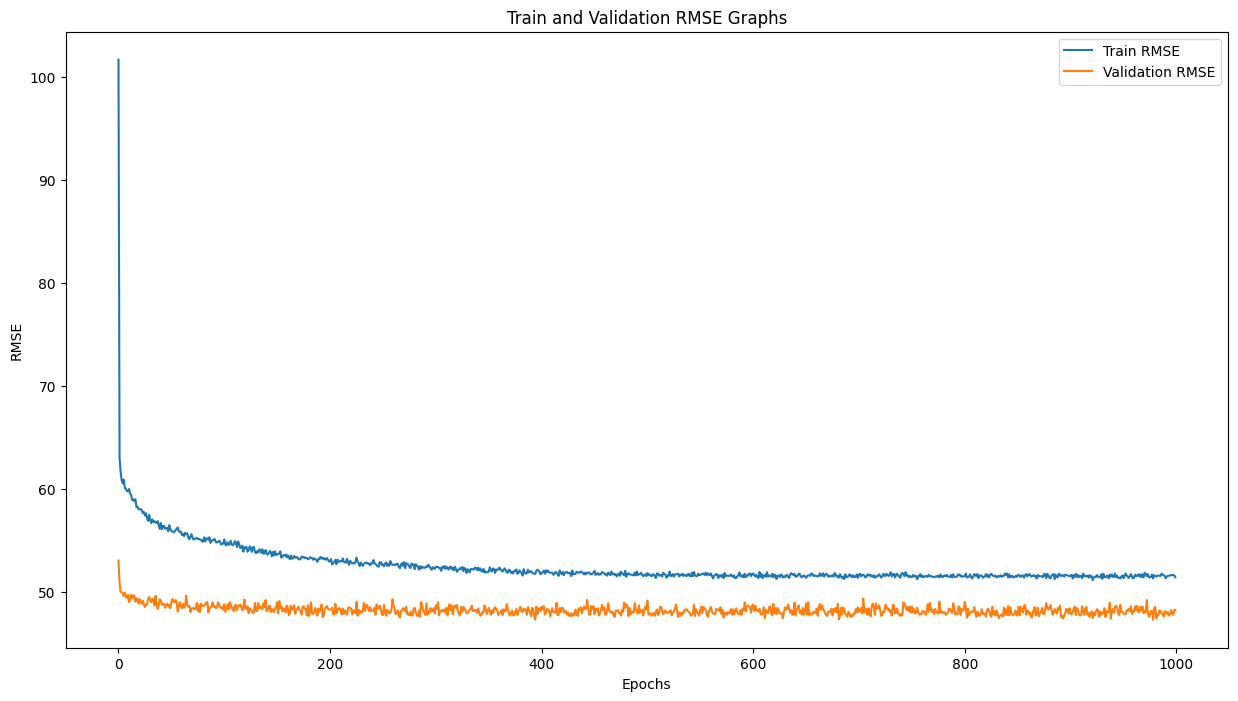

In [27]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Train and Validation RMSE Graphs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()


In [32]:
rmse_nn, mae_nn, r2_nn = regression_report(y_test, model.predict(X_test, verbose=0))

Regression Report:
+-------------------------+--------------------+
|         Metric          |       Score        |
+-------------------------+--------------------+
| Root Mean Squared Error | 47.099998474121094 |
|   Mean Absolute Error   | 32.970001220703125 |
|        R-squared        |        0.59        |
+-------------------------+--------------------+


#### Testing the model on this single case

In [37]:
test = pd.read_csv('test.csv')
test.drop(
    columns=['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'latitude', 
             'longitude', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count'], 
    inplace=True
    )
test

,bairro,room_type,price,minimo_noites,numero_de_reviews,disponibilidade_365
0,Midtown,Entire home/apt,225,1,45,355


In [38]:
test = pd.concat((test, pd.get_dummies(test['room_type'], dtype=np.uint8)), axis=1).drop(columns=['room_type'])
test = pd.concat((test, pd.get_dummies(test['bairro'], dtype=np.uint8)), axis=1).drop(columns=['bairro'])

In [39]:
# This is for get the columns that are missing
missing_columns = set(df_no_outlier.columns) - set(test.columns)
for column in missing_columns:
    test[column] = np.uint8(0)

In [40]:
# Loading the scaler saved on the beginning of the notebook
scaler_ = joblib.load('models-scalers/scaler_no_outlier.pkl')

In [41]:
X_ = test.drop(columns=['price']).values
X_ = scaler_.transform(X_)

In [42]:
# Loading the model saved above
model = joblib.load('models-scalers/model_neural_network_no_outlier.pkl')

Important point, for the model and the scaler to work well, the data must be in the same structure as the training here, which is why all the above treatment was necessary.

In [43]:
real = test['price'][0]
predicted = model.predict(X_, verbose=0)[0][0]

print(f"Real: {real:.2f}, Predicted: {predicted:.2f}")
print(f"Difference: {abs(real - predicted):.2f}")

Real: 225.00, Predicted: 89.20
Difference: 135.80


That is a little unexpected, the model in general is good (RMSE of 47), but on this particular case, the difference of the real and predicted is 135.80, bigger than with outliers.

#### Performance Summary

In [53]:
model_summary = pd.DataFrame(columns=['model', 'RMSE', 'R²'])
model_summary.loc[0] = ['Gradient Boosting', rmse_gbr, r2_gbr]
model_summary.loc[1] = ['Support Vector Machine', rmse_svr, r2_svr]
model_summary.loc[2] = ['Random Forest', rmse_random_forest, r2_random_forest]
model_summary.loc[3] = ['XGBoost', rmse_xgb, r2_xgb]
model_summary.loc[4] = ['Neural Network', rmse_nn, r2_nn]
model_summary.sort_values(by='RMSE')

,model,RMSE,R²
4,Neural Network,47.099998,0.59
0,Gradient Boosting,49.080000,0.55
2,Random Forest,50.010000,0.53
1,Support Vector Machine,53.100000,0.47
3,XGBoost,54.490002,0.45


As we deleted the outliers, the models are performing better than before. The best model is the Neural Network, with the lowest RMSE and the highest R². We went from a RMSE of 208 to 47, and from a R² of 0.13 to 0.55, so I think that the outlier cleaning was a good choice. On the solo test, without the outliers performed worse but in general, removing the outliers, decreased the variance and the metrics of the models improved.